In [20]:
import pandas as pd
from sklearn import preprocessing, metrics
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
import matplotlib.pylab as plt
from sklearn.model_selection import train_test_split,GridSearchCV, cross_val_score
from sklearn.preprocessing import MinMaxScaler,LabelEncoder,StandardScaler,Normalizer,OneHotEncoder,RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score,accuracy_score,roc_auc_score,precision_recall_fscore_support
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
import seaborn as sns
from sklearn.metrics import roc_curve,auc,confusion_matrix, matthews_corrcoef
import itertools
import numpy as np

In [2]:
from dmba import regressionSummary, exhaustive_search
from dmba import backward_elimination, forward_selection, stepwise_selection
from dmba import adjusted_r2_score, AIC_score, BIC_score
from dmba import classificationSummary, gainsChart, liftChart, plotDecisionTree

no display found. Using non-interactive Agg backend


In [3]:
data = pd.read_csv('encoded_data_unscaled.csv')
data.shape
#data.info()

(92359, 55)

In [4]:
X = data.drop('Score',axis=1)
y = data.Score.values
std = StandardScaler()

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33, random_state=42)

# **Naive Bayes Classifier**

In [6]:
NaiveBayes = MultinomialNB(class_prior=[0.5,0.5])

param = {'alpha': [0.0001,0.001,0.01,0.1,1,10,100,1000]}

#for the bow based model
NB = GridSearchCV(NaiveBayes,param,cv = None,refit=False,return_train_score=True,scoring='roc_auc')
NB.fit(X_train,y_train)
NB.best_params_

{'alpha': 100}

In [7]:
NBclf = MultinomialNB(alpha= 100, fit_prior=True, class_prior=[0.5,0.5])
std.fit_transform(X_train,y_train)
NBclf.fit(X_train,y_train)

MultinomialNB(alpha=100, class_prior=[0.5, 0.5])

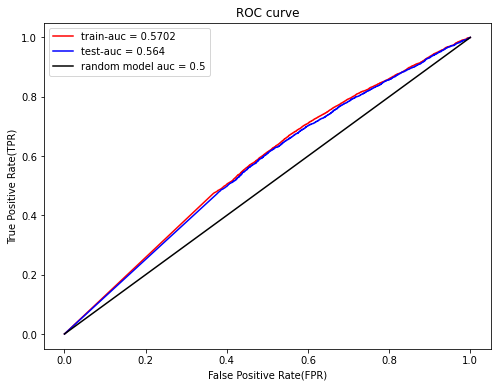

Best AUC for the model is 0.564 


In [8]:
#predicted value of y probabilities
y_pred_train = NBclf.predict_proba(X_train)
y_pred_test = NBclf.predict_proba(X_test)

#predicted values of Y labels
pred_label_train = NBclf.predict(X_train)
pred_label_test = NBclf.predict(X_test)

#Confusion Matrix
cf_matrix_train = confusion_matrix(y_train,pred_label_train)
cf_matrix_test = confusion_matrix(y_test,pred_label_test)

fpr_train,tpr_train,threshold_train = roc_curve(y_train,y_pred_train[:,1])
fpr_test,tpr_test,threshold_test = roc_curve(y_test,y_pred_test[:,1])

train_auc = round(auc(fpr_train,tpr_train),4)
test_auc = round(auc(fpr_test,tpr_test),4)

%matplotlib inline
plt.figure(figsize=(8,6))
plt.plot(fpr_train,tpr_train,color='red',label='train-auc = '+str(train_auc))
plt.plot(fpr_test,tpr_test,color='blue',label='test-auc = '+str(test_auc))
plt.plot(np.array([0,1]),np.array([0,1]),color='black',label='random model auc = '+str(0.5))
plt.xlabel('False Positive Rate(FPR)')
plt.ylabel('True Positive Rate(TPR)')
plt.title('ROC curve')
plt.legend()
plt.show()
print('Best AUC for the model is {} '.format(test_auc))

In [9]:
NB_pred = NBclf.predict(X_test)
NB_proba = NBclf.predict_proba(X_test)
NB_result = pd.DataFrame({'actual': y_test, 
                             'p(0)': [p[0] for p in NB_proba],
                             'p(1)': [p[1] for p in NB_proba],
                             'predicted': NB_pred })
# display four different cases
cases = [i for i in range(20,30,1)]
print(NB_result.loc[cases])

    actual          p(0)          p(1)  predicted
20     1.0  6.632237e-15  1.000000e+00        1.0
21     1.0  8.351471e-08  9.999999e-01        1.0
22     1.0  2.516930e-09  1.000000e+00        1.0
23     0.0  2.641059e-17  1.000000e+00        1.0
24     1.0  2.288637e-57  1.000000e+00        1.0
25     1.0  1.000000e+00  5.881075e-11        0.0
26     1.0  4.907571e-17  1.000000e+00        1.0
27     1.0  1.341011e-88  1.000000e+00        1.0
28     0.0  1.730345e-28  1.000000e+00        1.0
29     1.0  1.339145e-36  1.000000e+00        1.0


**GainsChart and LiftChart**

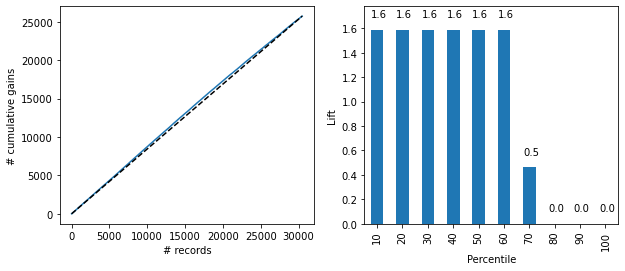

In [10]:
df = NB_result.sort_values(by=['p(1)'], ascending=False)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
gainsChart(df.actual, ax=axes[0])
liftChart(df['p(1)'], title=False, ax=axes[1])
plt.show()

**Confusion Matrix**

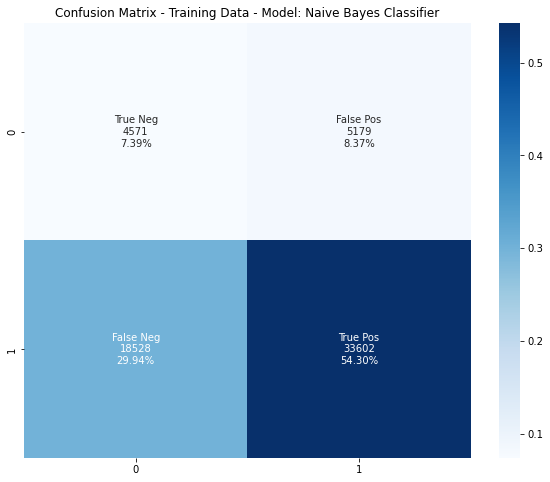

In [11]:
plt.figure(figsize=(10,8))
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix_train.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix_train.flatten()/np.sum(cf_matrix_train)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix_train/np.sum(cf_matrix_train), annot= labels ,fmt= '', cmap='Blues')
plt.title('Confusion Matrix - Training Data - Model: Naive Bayes Classifier')
plt.show()

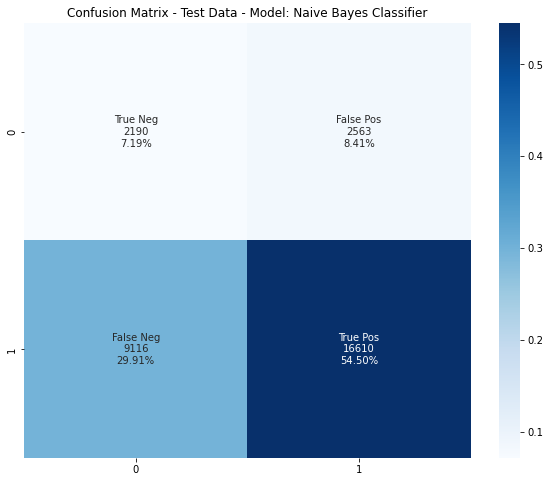

In [12]:
plt.figure(figsize=(10,8))
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix_test.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix_test.flatten()/np.sum(cf_matrix_test)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix_test/np.sum(cf_matrix_test), annot= labels ,fmt= '', cmap='Blues')
plt.title('Confusion Matrix - Test Data - Model: Naive Bayes Classifier')
plt.show()

In [13]:
regressionSummary(y_train, NBclf.predict(X_train))


Regression statistics

               Mean Error (ME) : 0.2157
Root Mean Squared Error (RMSE) : 0.6190
     Mean Absolute Error (MAE) : 0.3831


In [14]:
print('F1 Score = ',round(f1_score(y_test, np.round(NBclf.predict(X_test),0), average='micro'),5))

F1 Score =  0.61682


In [16]:
print('AIC', AIC_score(y_test, NBclf.predict(X_test), df = len(X_train.columns) + 1))

AIC 57370.8095441085


In [27]:
matthews_corrcoef(y_test, NBclf.predict(X_test))

0.07992099282441725

# **k-Nearest Neighbours Classifier**

In [133]:
results = []
for k in range(1, 25):
    knn = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)
    results.append({
        'k': k,
        'accuracy': accuracy_score(y_test, knn.predict(X_test))
                    })

In [134]:
pd.DataFrame(results)

,k,accuracy
0,1,0.820729
1,2,0.753174
2,3,0.833164
3,4,0.806588
4,5,0.838676
5,6,0.824338
6,7,0.840776
7,8,0.833918
8,9,0.843433
9,10,0.839660


In [21]:
knn = KNeighborsClassifier(n_neighbors= 21).fit(X_train,y_train)

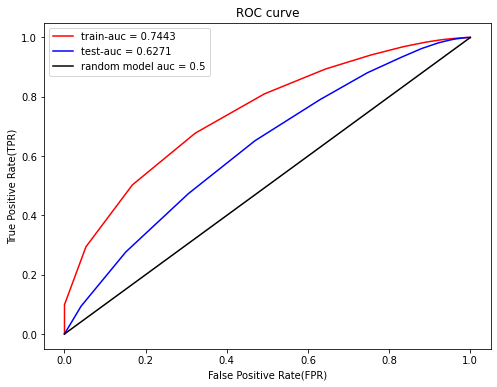

Best AUC for the model is 0.6271 


In [145]:
#predicted value of y probabilities
y_pred_train = knn.predict_proba(X_train)
y_pred_test = knn.predict_proba(X_test)

#predicted values of Y labels
pred_label_train = knn.predict(X_train)
pred_label_test = knn.predict(X_test)

#Confusion Matrix
cf_matrix_train = confusion_matrix(y_train,pred_label_train)
cf_matrix_test = confusion_matrix(y_test,pred_label_test)

fpr_train,tpr_train,threshold_train = roc_curve(y_train,y_pred_train[:,1])
fpr_test,tpr_test,threshold_test = roc_curve(y_test,y_pred_test[:,1])

train_auc = round(auc(fpr_train,tpr_train),4)
test_auc = round(auc(fpr_test,tpr_test),4)

%matplotlib inline
plt.figure(figsize=(8,6))
plt.plot(fpr_train,tpr_train,color='red',label='train-auc = '+str(train_auc))
plt.plot(fpr_test,tpr_test,color='blue',label='test-auc = '+str(test_auc))
plt.plot(np.array([0,1]),np.array([0,1]),color='black',label='random model auc = '+str(0.5))
plt.xlabel('False Positive Rate(FPR)')
plt.ylabel('True Positive Rate(TPR)')
plt.title('ROC curve')
plt.legend()
plt.show()
print('Best AUC for the model is {} '.format(test_auc))

In [146]:
knn_pred = knn.predict(X_test)
knn_proba = knn.predict_proba(X_test)
knn_result = pd.DataFrame({'actual': y_test, 
                             'p(0)': [p[0] for p in knn_proba],
                             'p(1)': [p[1] for p in knn_proba],
                             'predicted': knn_pred })
# display four different cases
knn_result.head()

,actual,p(0),p(1),predicted
0,0.0,0.428571,0.571429,1.0
1,1.0,0.142857,0.857143,1.0
2,1.0,0.095238,0.904762,1.0
3,1.0,0.047619,0.952381,1.0
4,1.0,0.190476,0.809524,1.0


**LiftChart and GainsChart**

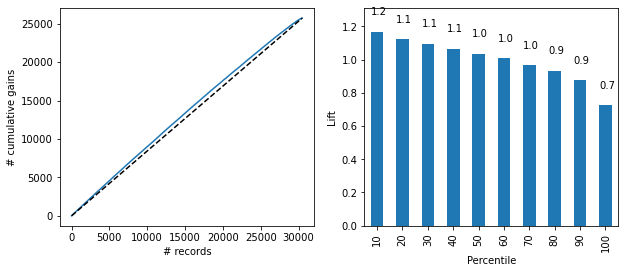

In [147]:
df = knn_result.sort_values(by=['p(1)'], ascending=False)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
gainsChart(df.actual, ax=axes[0])
liftChart(df['p(1)'], title=False, ax=axes[1])
plt.show()

**Confusion Matrix**

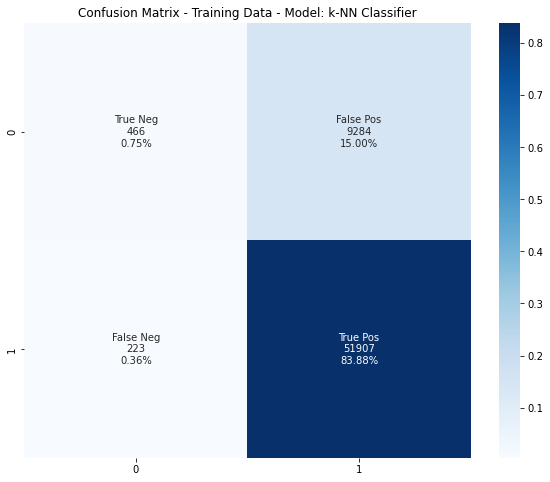

In [148]:
plt.figure(figsize=(10,8))
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix_train.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix_train.flatten()/np.sum(cf_matrix_train)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix_train/np.sum(cf_matrix_train), annot= labels ,fmt= '', cmap='Blues')
plt.title('Confusion Matrix - Training Data - Model: k-NN Classifier')
plt.show()

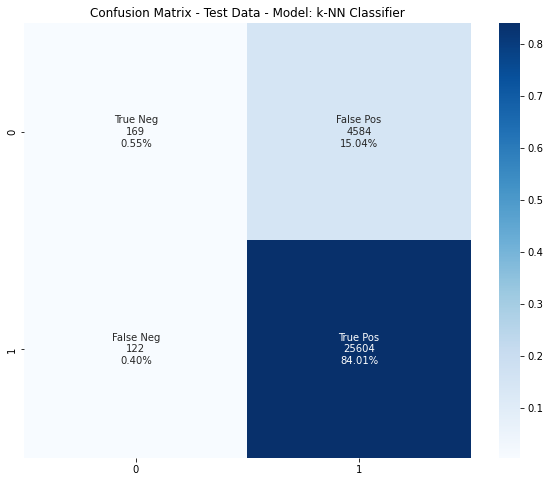

In [149]:
plt.figure(figsize=(10,8))
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix_test.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix_test.flatten()/np.sum(cf_matrix_test)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix_test/np.sum(cf_matrix_test), annot= labels ,fmt= '', cmap='Blues')
plt.title('Confusion Matrix - Test Data - Model: k-NN Classifier')
plt.show()

In [152]:
regressionSummary(y_train, pred_label_train)


Regression statistics

               Mean Error (ME) : -0.1464
Root Mean Squared Error (RMSE) : 0.3920
     Mean Absolute Error (MAE) : 0.1536


In [159]:
print('F1 Score = ',round(f1_score(y_test,knn_pred, average='micro'),5))

F1 Score =  0.8456


In [19]:
print('AIC', AIC_score(y_test, knn.predict(X_test), df = len(X_train.columns) + 1))

AIC 29666.79853628196


In [26]:
matthews_corrcoef(y_test, knn.predict(X_test))

0.11496280832029461